# 0. Правила курса
10 блоков, в каждом:
- лекция
- семинар
- домашнее задание

В конце курса проект - создание платформы AB тестирования для онлайн магазина электроники.

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Распределение Стьюдента. Критическая область

Как обсуждалось на лекции, мы должны выдвинуть нулевую гипотезу $H_0$ против некоторой альтернативы $H_1$. При тестировании мы проверяем значение некоторой статистики. Даже в условиях справедливости нулевой гипотезы указанная статистика может сильно отличаться от ожидаемых значений --- эта статистика представляет некоторую случайную величину.

Рассматривая интересующую нас статистику мы должны помнить о том как <b>распределена</b> случайная величина при условии справедливости нулевой гипотезы.



### Распределение Стьюдента

Для выборки $X_1, X_2, \ldots, X_n \sim N(\mu, \sigma^2)$ из нормального распределения с неизвестной дисперсией мы можем определить статистику: 

$$ 
    \left<X\right> = \frac1n \sum_{i=1}^n X_i,\quad
    S^2 = \frac1{n-1} \sum_{i=1}^n (X_i - \left<X\right>)^2, \quad
    t = \frac{\left<X\right> - \mu}{S / \sqrt{n}}.    
$$

При этом случайная величина $t$ имеет распределение Стьюдента с (n-1) степерью свободы. При росте n распределение стремится к нормальному, но в практически значимых случаях конечных выборок у этого распределения значительно более тяжелые хвосты, что повышает шансы заметных отклонений.

Распределение используется в статистике для точечного оценивания, построения доверительных интервалов и тестирования гипотез, касающихся неизвестного среднего выборки из нормального распределения.

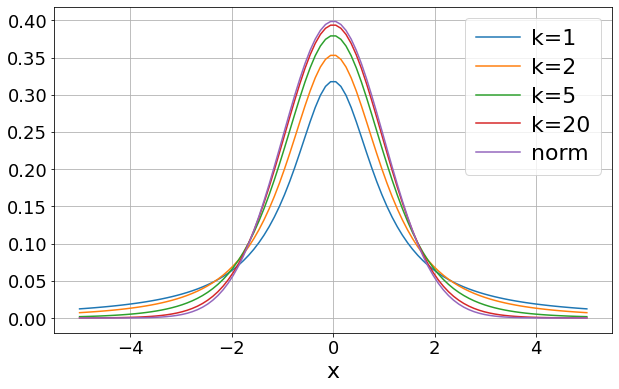

In [3]:
# распределение статистики стьюдента
X = np.linspace(-5, 5, 100)

list_k = [1, 2, 5, 20]

for k in list_k:
    Y = stats.t.pdf(X, k)
    plt.plot(X, Y, label=f'k={k}')

Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, label='norm')

plt.legend()
plt.xlabel('x')
plt.grid()
plt.show()

Есть две выборки: $X_1,\ldots,X_{n_1}\sim N(\mu_1, \sigma_1)$ и $Y_1,\ldots,Y_{n_2}\sim N(\mu_2, \sigma_2)$.
    
Гипотезы: $H_0: \mathbb{E}{X} = \mathbb{E}{Y}$ и $H_1: \mathbb{E}{X} \neq \mathbb{E}{Y}$.

Статистика теста
$$t(X^n, Y^n) = \dfrac{\overline{Y} - \overline{X}}{\sqrt{\dfrac{S^2_X}{n_1} + \dfrac{S^2_Y}{n_2}}} \approx St(\nu), \qquad \nu = \frac{\left(\dfrac{S^2_X}{n_1} + \dfrac{S^2_Y}{n_2}\right)^2}{\dfrac{S_X^4}{n_1^2 (n_1 - 1)} + \dfrac{S_Y^4}{n_2^2 (n_2 - 1)}}$$

Самостоятельно реализуем вычисление t-статистики: 

In [4]:
def get_student_parameter(data_one: np.array, data_two: np.array) -> float:
    """Вычисляет параметр функции распределения Стьюдента."""
    len_one, len_two = len(data_one), len(data_one)
    mean_one, mean_two = np.mean(data_one), np.mean(data_two)
    std_one, std_two = np.std(data_one), np.std(data_two)
    k = (
        ((std_one ** 2) / len_one + (std_two ** 2) / len_two) ** 2
        / (
            (std_one ** 4) / ((len_one ** 2) * (len_one - 1))
            + (std_two ** 4) / ((len_two ** 2) * (len_two - 1))
        )
    )
    return k


def get_ttest_statistic(data_one: np.array, data_two: np.array) -> float:
    """Считает статистику Стьюдента"""
    len_one = len(data_one)
    len_two = len(data_two)
    mean_one = np.mean(data_one)
    mean_two = np.mean(data_two)
    std_one = np.std(data_one, ddof=1)
    std_two = np.std(data_two, ddof=1)
    t = (mean_one - mean_two) / np.sqrt((std_two**2 / len_two) + (std_one**2 / len_one))
    return t

In [5]:
# данные для примера
np.random.seed(44)
sample_size = 100
data_control = -np.random.normal(1, 1, sample_size)
data_pilot = -np.random.normal(1.2, 1, sample_size)


k = get_student_parameter(data_control, data_pilot)
print(f'student_parameter = {k}')

alpha = 0.05
critical_region_bounds = stats.t.ppf([alpha/2, 1 - alpha/2], df=k)
print(f'critical_region_bounds = {critical_region_bounds}')

ttest_statistic = get_ttest_statistic(data_control, data_pilot)
print(f'ttest_statistic = {ttest_statistic}')

pvalue = stats.t.cdf(-np.abs(ttest_statistic), df=k) * 2
print(f'pvalue = {pvalue}')

# сверим с готовой реализацией
print(f'stats.ttest_ind = {stats.ttest_ind(data_control, data_pilot)}')

student_parameter = 196.53643393447297
critical_region_bounds = [-1.97210778  1.97210778]
ttest_statistic = 1.8203056424009751
pvalue = 0.0702335577441075
stats.ttest_ind = Ttest_indResult(statistic=1.8203056424009751, pvalue=0.07022230781028711)


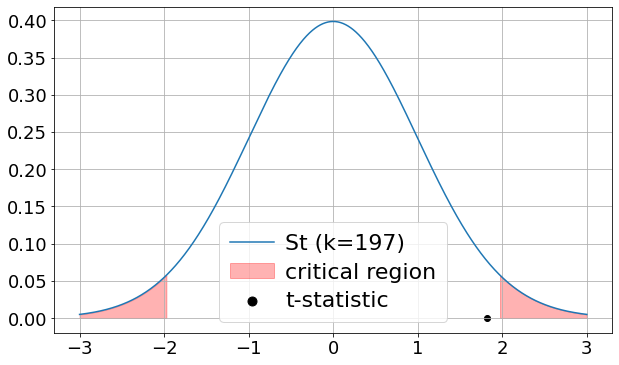

In [6]:
# визуализация
X = np.linspace(-3, 3, 1000)
Y = stats.t.pdf(X, k)

plt.plot(X, Y, label=f'St (k={k:0.0f})')

# critical region
critical_mask_list = [X < critical_region_bounds[0], X > critical_region_bounds[1]]
for idx, mask in enumerate(critical_mask_list):
    X_ = X[mask]
    Y_upper = Y[mask]
    Y_down = np.zeros(len(Y_upper))
    plt.fill_between(
        X_, Y_down, Y_upper,
        color='r', alpha=0.3,
        label='critical region' if idx==0 else ''
    )

plt.scatter([ttest_statistic], [0], color='k', label='t-statistic')

plt.legend()
plt.grid()
plt.show()

# 2. Статистические тесты.

Библиотека [SciPy](https://www.scipy.org/) предоставляет много удобных модулей для математических расчетов, активно используется научными сотрудниками и инженерами.

В рамках нашего курса больше всего пригодится модуль статистики: [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Так в этом модуле представлены ститистические тесты, рассмотренные нами на лекции:

[scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind):
```
scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='two-sided')
```

[scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu)
```
scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)
```

Так же там представлено множество других полезных функций.

In [7]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)


def check_mannwhitneyu(a, b, alpha=0.05):
    """Тест Манн-Уитни. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.mannwhitneyu(a, b, alternative='two-sided')
    return int(pvalue < alpha)


def check_bootstrap(a, b, func=np.mean, B=1000, alpha=0.05):
    """Бутстрап. Возвращает 1, если отличия значимы."""
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))
    list_diff = func(a_bootstrap, axis=0) - func(b_bootstrap, axis=0)
    left_bound = np.quantile(list_diff, alpha / 2)
    right_bound = np.quantile(list_diff, 1 - alpha / 2)
    res = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return res


dict_tests = {
    'ttest': check_ttest,
    'mannwhitneyu': check_mannwhitneyu,
    'bootstrap': check_bootstrap
}

### Проверим, что тесты работают корректно
Запустим их на выборках из одинаковых распределений, убедимся что они редко ошибочно находят эффект.

In [8]:
significant_results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0, 1, 100)
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))

print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()})


{'ttest': 0.045, 'mannwhitneyu': 0.045, 'bootstrap': 0.051}


Теперь будем генерить выборки из распределений с разными средними, тесты должны начать находить значимые отличия чаще.

In [9]:
significant_results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0.4, 1, 100)
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))

print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()})


{'ttest': 0.824, 'mannwhitneyu': 0.793, 'bootstrap': 0.828}


### Скорость работы
Видим, что вычисления занимают некоторое время. Сравним скорость вычисления тестов в зависимости от размера выборки.

In [10]:
test_times = {test_name: [] for test_name in dict_tests}
sample_sizes = np.logspace(2, 5, 20).astype(int)

for sample_size in tqdm(sample_sizes):
    a = np.random.normal(0, 1, sample_size)
    b = np.random.normal(0, 1, sample_size)
    for test_name, test in dict_tests.items():
        t1 = time.time()
        test(a, b)
        t2 = time.time()
        test_times[test_name].append(t2 - t1)

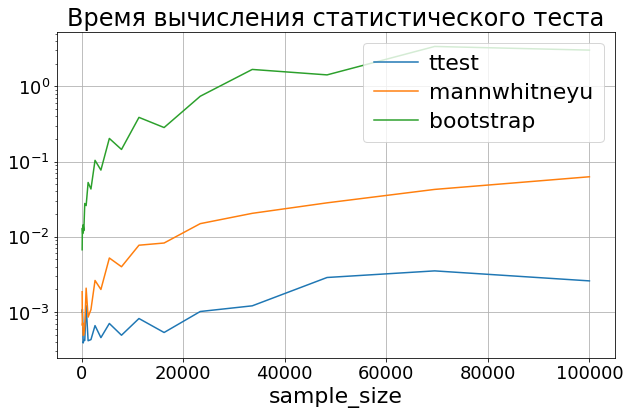

In [11]:
for test_name, times in test_times.items():
    plt.plot(sample_sizes, times, label=test_name)
plt.title('Время вычисления статистического теста')
plt.grid()
plt.xlabel('sample_size')
plt.yscale('log')
plt.legend()
plt.show()

Видно, что ttest сильно быстрей. Время работы теста Манн-Уитни и бутстрапа заметно растут при увеличении объёма данных.

Заметим, что бутстреп на несколько порядков медленнее. Он полезен для построения доверительных интервалов оценок, но для проверки гипотез о равенстве средних на больших данных его лучше не использовать из-за скорости работы.

In [12]:
dict_tests = {test_name: dict_tests[test_name] for test_name in ['ttest', 'mannwhitneyu']}

## Ошибки первого и второго рода

Для проверки корректности работы статистических тестов на практике принято применять технологию <b>AAB-тестирования</b>. По возможности мы стараемся подобрать две выборки из контрольной группы и одну из пилотной. Если всё идет хорошо, то алгоритм должен заметить разницу между пилотной и контрольной выборками, но при этом не показать различия между двумя контрольными группами.

<b>Вероятность ошибки первого рода</b> --- вероятность отвергнуть нулевую гипотезу при условии, что она верна. То есть вероятность обнаружить значимые различия между двумя контрольными группами. Ведь их не должно быть!

<b>Вероятность ошибки второго рода</b> --- вероятность не отвергнуть нулевую гипотезу при условии, что верна альтернативная гипотеза. То есть вероятность не найти значимых различий между пилотной и контрольной группами. А мы очень хотим их найти!


Создадим вспомогательные функции для проведения экспериментов.

In [13]:
def aab_samples_generator(dist_a, dist_b):
    def _get_aab_sample(sample_size):
        a_one = dist_a.rvs(size=sample_size)
        a_two = dist_a.rvs(size=sample_size)
        b = dist_b.rvs(size=sample_size)
        return (a_one, a_two, b)
    return _get_aab_sample

def run_experiment(sample_sizes, aab_sample_generator, N=1000):
    first_type_errors = defaultdict(list)
    second_type_errors = defaultdict(list)
            
    for sample_size in tqdm(sample_sizes):
        aa_results = defaultdict(list)
        ab_results = defaultdict(list)
        for _ in range(N):
            a_one, a_two, b = aab_sample_generator(sample_size)
            for name, test in dict_tests.items():
                aa_results[name].append(test(a_one, a_two))
                ab_results[name].append(test(a_one, b))
        
        for name in dict_tests:
            first_type_errors[name].append(np.mean(aa_results[name]))
            second_type_errors[name].append(1 - np.mean(ab_results[name]))

    return sample_size, first_type_errors, second_type_errors

def plot_errors(x, data: dict, title='', xlabel=''):
    for key, values in data.items():
        plt.plot(x, values, label=key)
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()
    plt.show()

### Сравнение двух смещенных нормальных распределений

Посмотрим как справятся наши тесты с двумя смещенными на небольшую величину нормальными распределениями. Удастся ли нам различить их на заданном уровне значимости?

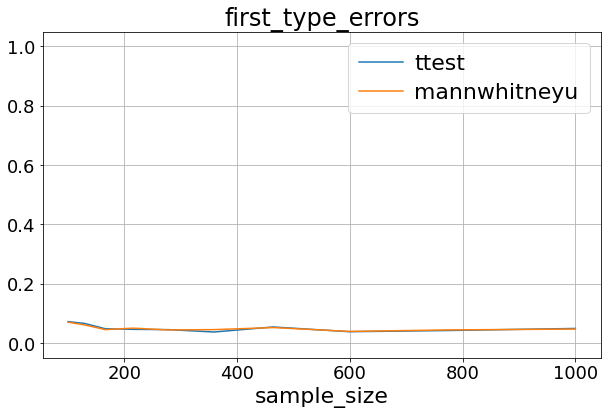

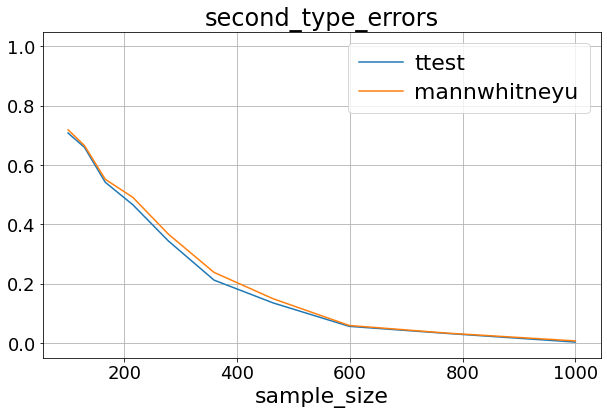

In [14]:
sample_sizes = np.logspace(2, 3, 10).astype(int)

generator = aab_samples_generator(
    dist_a=stats.norm(loc=0, scale=1),
    dist_b=stats.norm(loc=0.2, scale=1)
)

_, first_type_errors, second_type_errors = run_experiment(sample_sizes, generator)

plot_errors(sample_sizes, first_type_errors, 'first_type_errors', 'sample_size')
plot_errors(sample_sizes, second_type_errors, 'second_type_errors', 'sample_size')

Ошибки первого типа держаться на уровне 0.05, а ошибки второго уровня уменьшаются при увеличении выборки. Результаты для теста Стьюдента и теста Манна-Уитни очень похожи, тест Стьюдента может едва выигрывает в точности.

### Сравнение для не нормально-распределенных данных

Проверим как будут вести себя тесты при генерации данных из экспоненциального распределения.

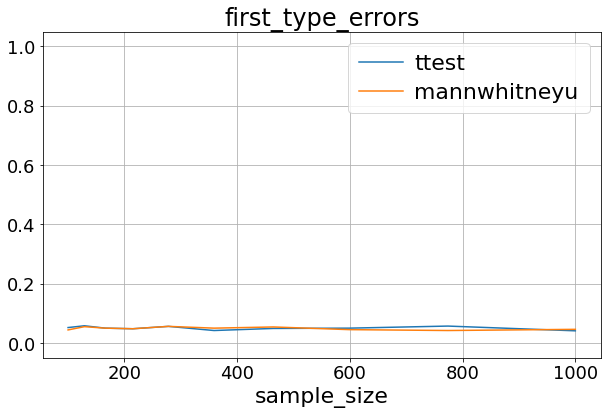

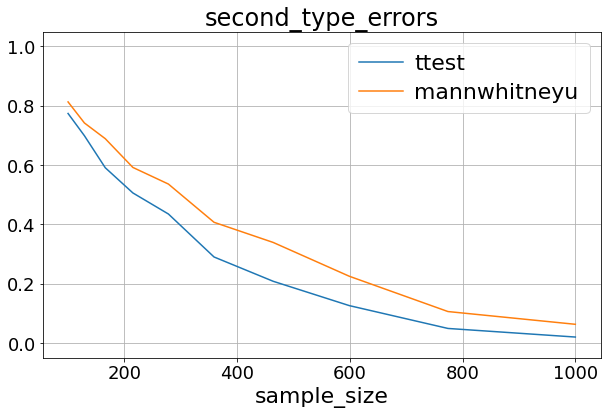

In [15]:
sample_sizes = np.logspace(2, 3, 10).astype(int)

generator = aab_samples_generator(
    dist_a=stats.expon(loc=0, scale=1.0),
    dist_b=stats.expon(loc=0, scale=1.2)
)

_, first_type_errors, second_type_errors = run_experiment(sample_sizes, generator)

plot_errors(sample_sizes, first_type_errors, 'first_type_errors', 'sample_size')
plot_errors(sample_sizes, second_type_errors, 'second_type_errors', 'sample_size')

Тест Стьюдента в этой задаче дает меньше ошибок.

### Чувствительность к выбросам
Проверим как ведут себя тесты при наличии выбросов в данных.

Зафиксируем размер выборки, будем заменять одно значений в одной выборке на сильно отличающееся от среднего.

In [16]:
N = 1000

outliers = np.arange(-150, 300 + 1, 15)
test_first_type_errors = defaultdict(list)
test_second_type_errors = defaultdict(list)
sample_size = 500

for outlier in tqdm(outliers):
    test_first_type_results = defaultdict(list)
    test_second_type_results = defaultdict(list)
    for _ in range(N):
        a_one = np.random.normal(0, 1, sample_size)
        a_one[0] = outlier
        a_two = np.random.normal(0, 1, sample_size)
        b = np.random.normal(0.2, 1, sample_size)
        for test_name, test in dict_tests.items():
            result_aa = test(a_one, a_two)
            result_ab = test(a_one, b)
            test_first_type_results[test_name].append(result_aa)
            test_second_type_results[test_name].append(result_ab)
    
    for test_name in dict_tests:
        test_first_type_errors[test_name].append(np.mean(test_first_type_results[test_name]))
        test_second_type_errors[test_name].append(1 - np.mean(test_second_type_results[test_name]))

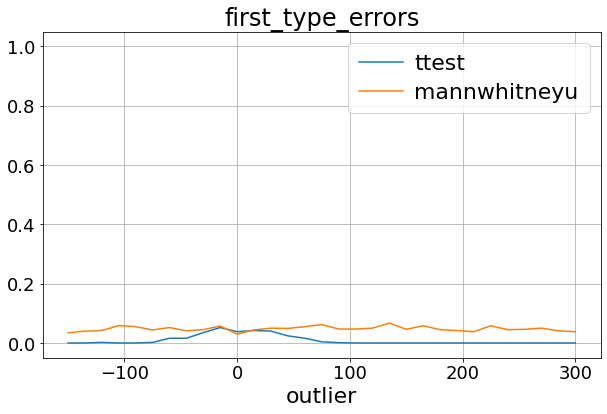

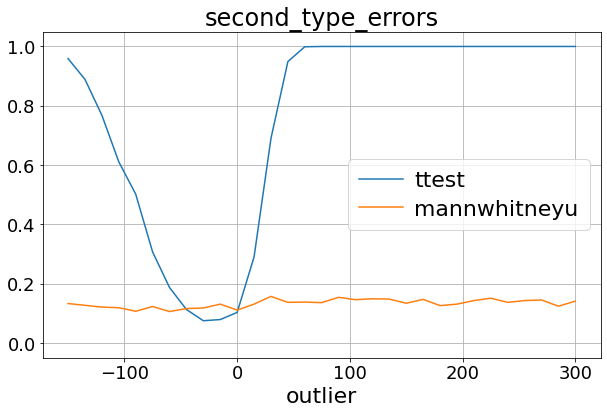

In [17]:
plot_errors(outliers, test_first_type_errors, 'first_type_errors', 'outlier')
plot_errors(outliers, test_second_type_errors, 'second_type_errors', 'outlier')

Видно, что при увеличении размера выброса, ошибка второго рода для теста Стьюдента сильно увеличивается, когда тест Манна-Уитни не обращает большого внимания на выброс. Связано это с тем, что тест Стьюдента - параметрический тест и отдельный выброс портит нам параметры. В то время как Манн-Уитни основан на рангах элементов. То есть один испорченный объект портит значения только в связанных с ним парах, но не затрагивает остальные. В этом смысле мы получаем большую устойчивость к редким большим выбросам.

In [18]:
N = 1000

outliers = np.arange(-150, 300 + 1, 15)
test_first_type_errors = defaultdict(list)
test_second_type_errors = defaultdict(list)
sample_size = 500

for outlier in tqdm(outliers):
    test_first_type_results = defaultdict(list)
    test_second_type_results = defaultdict(list)
    for _ in range(N):
        a_one = np.random.normal(0, 1, sample_size)
        a_one[:5] = outlier
        a_two = np.random.normal(0, 1, sample_size)
        b = np.random.normal(0.2, 1, sample_size)
        for test_name, test in dict_tests.items():
            result_aa = test(a_one, a_two)
            result_ab = test(a_one, b)
            test_first_type_results[test_name].append(result_aa)
            test_second_type_results[test_name].append(result_ab)
    
    for test_name in dict_tests:
        test_first_type_errors[test_name].append(np.mean(test_first_type_results[test_name]))
        test_second_type_errors[test_name].append(1 - np.mean(test_second_type_results[test_name]))

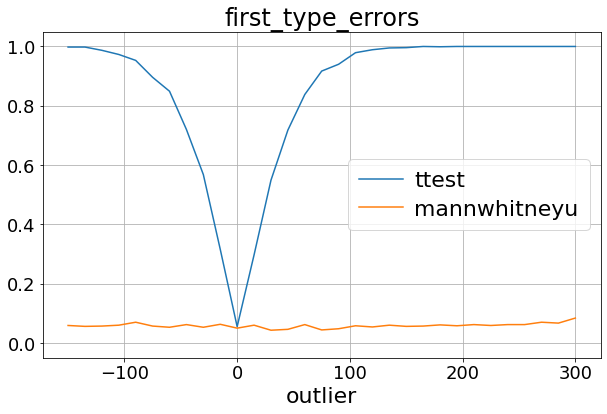

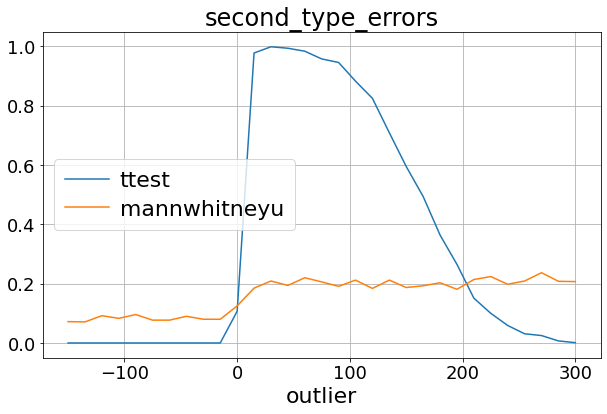

In [19]:
plot_errors(outliers, test_first_type_errors, 'first_type_errors', 'outlier')
plot_errors(outliers, test_second_type_errors, 'second_type_errors', 'outlier')

# 3. Бутстрап и доверительные интервалы

Суть метода бутстрап состоит в том, чтобы по имеющейся выборке мы можем построить эмпирическое распределение. Это эмпирическое распределение будет апроксимировать исходное неизвестное нам распределение.

Для того, чтоб узнать значение произвольной статистики мы можем сгенерировать случайную выборку из распределения. Поскольку настоящее распределение нам неизвестно, то мы заменяем его апроксимацией --- указанным ранее эмпирическим распределением. Напомним, что генерация выборки из эмпирического распределения эквивалентна выбору с возвращениями из породившей это эмпирическое распределение выборки. Такой выбор на практике удобно осуществлять с помощью функции [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html):

```
random.choice(a, size=None, replace=True, p=None)
```
При этом мы можем указать размер выборки --- произвольный кортеж натуральных чисел. Такой способ гораздо эффективнее, чем последовательно генерировать несколько выборок.

Каждая из порожденных выборок дает нам точечную оценку для интересующей нас статистики. В целом же многократно сгенерированные выборки дают нам возможность построить распределение интересующей статистики.

## Нахождение распределение статистики с помощью бутстрапа

<b>Задача</b>. Сгенерируем выборку из [экспоненциального распределения](https://en.wikipedia.org/wiki/Exponential_distribution). На её основе можно сформировать множество бутстрепных подвыборок. Наша задача посчитать точечную оценку для коэффициента ассиметрии, а так же на основе бутстрепных оценок построить распределение для этой статистики. И указать доверительный интервал. Сравнить всё это с известным теоретическим значением коэффициента ассиметрии для экспоненциального распределения. 

### Генерируем выборку из распределения

Модуль scipy.stats предоставляет много классических распределений. Так мы можем рассмотреть экспоненциальное распределение [scipy.stats.expon](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon):

```
scipy.stats.expon(*args, **kwds)
```

В модуле stats распределения относятся к типу <scipy.stats._continuous_distns.expon_gen object>. Объекты этого типа имеют стандартный интерфейс с методом .rvs в который мы можем передать размер генерируемой выборки.

In [20]:
N = 100

distribution = stats.expon(loc=0, scale=1)

X = distribution.rvs(size=N, random_state=23)

Мы можем визуализировать полученную выборку в виде гистограммы. Для этого прекрасно подойдет функция [seaborn.histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot)

```
seaborn.histplot(data=None, *, x=None, y=None, hue=None, weights=None, 
    stat='count', bins='auto', binwidth=None, binrange=None, discrete=None,
    cumulative=False, common_bins=True, common_norm=True, multiple='layer',
    element='bars', fill=True, shrink=1, kde=False, kde_kws=None, 
    line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None,
    cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, 
    log_scale=None, legend=True, ax=None, **kwargs)
```

Ознакомьтес с её описанием. В частности она может для данной выборки провести регрессионный анализ и попытаться найти наилучшее соответствие с распределением из пакета scipy.stats.

Полученный график можно сравнить с плотностью настоящего распределения, для обращения к которой существует метод .pdf

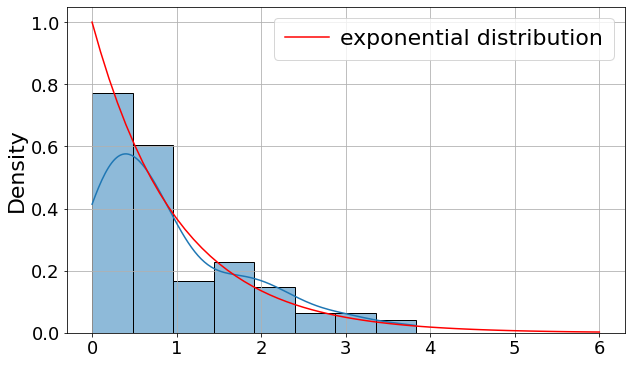

In [21]:
x = np.linspace(0, 6, 61)
pdf = distribution.pdf(x)

sns.histplot(data=X, kde=True, stat='density')
plt.plot(x, pdf, label='exponential distribution', c='r')
plt.legend()
plt.grid()

Так же можно легко построить эмпирическую функцию распределения и сравнить её с настоящей:

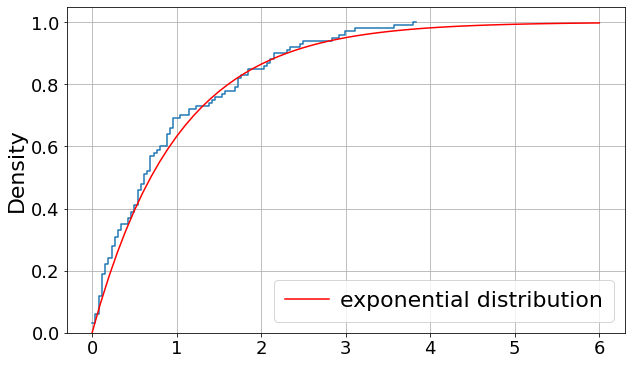

In [22]:
cdf = distribution.cdf(x)

sns.histplot(
    data=X, cumulative=True, stat='density', 
    fill=False, element='step', bins=100)
plt.plot(x, cdf, label='exponential distribution', c='r')
plt.legend()
plt.grid()

## Точечная оценка статистики

Мы можем для нашей выборки получить точечную оценку [коэффициента ассиметрии](https://en.wikipedia.org/wiki/Skewness). Напомним, что вычисляется он как  
$$
\kappa=\frac{\mathbb{E}(X-\mu)^3}{\sigma^3}
$$
$$
\hat{\kappa}=\frac{n^{-1}\sum_i(X_i - \hat{\mu})^3}{\left(n^{-1}\sum_i(X_i - \hat{\mu})^2 \right)^{3/2}}
$$

Для практического вычисления можно воспользоваться функцией [scipy.stats.skew](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html).

Так мы можем посчитать точечную оценку для нашей выборки и сравнить с известным значением для распределения. Кстати, если оно не известно, то его можно запросить.

In [23]:
sample_skewness = stats.skew(X)
distribution_skewness = distribution.stats(moments='s')

print(f'Коэффициент асимметрии распределения : {distribution_skewness}')
print(f'Коэффициент асимметрии выборки       : {sample_skewness}')

Коэффициент асимметрии распределения : 2.0
Коэффициент асимметрии выборки       : 1.2274496724312205


## Процедура бутстрап и построение доверительных интервалов

С помощью бутстрепа мы можем из имеющейся выборки сгенерировать множество подвыборок. Для каждой из этих подвыборок можно построить точечную оценку и тем самым получить распределение бутстрепных точечных оценок для интересующей нас статистики.

Для таких распределений мы можем построить доверительные интервалы. Например, доверительный интервал на основе процентилей.

In [24]:
B = 10000
real_mean_f = distribution.stats(moments='s')

list_points = []
count_x = np.arange(20, 101, 5)

for size in tqdm(count_x):
    sub_X = X[:size]

    bootstrap_X = np.random.choice(sub_X, size=(size, B))
    bootstrap_skewness = stats.skew(bootstrap_X, axis=0)
    list_points.append(bootstrap_skewness)
  
alpha = 0.05

array_points = np.array(list_points)
bounds = np.quantile(array_points, [alpha/2, 1-alpha/2], axis=1)
means = np.mean(array_points, axis=1)

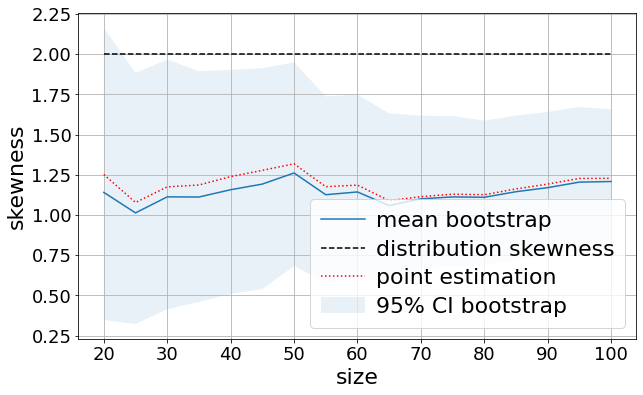

In [25]:
plt.fill_between(count_x, bounds[0], bounds[1], alpha=0.1, label='95% CI bootstrap')
plt.plot(count_x, means, label='mean bootstrap')
plt.plot(count_x, np.full(len(count_x), distribution_skewness), '--k', label='distribution skewness')
plt.plot(count_x, [stats.skew(X[:size]) for size in count_x], ':r', label='point estimation')
plt.legend()
plt.xlabel('size')
plt.ylabel('skewness')
plt.grid()
plt.show()

Важно заметить, что при всей мощи бутстрепа он не может преодолеть недостатки конкретной выборки. Если сгенерированная нами выборка не отражает определенных свойств исходного распределения, то бутстрепу дополнительную информацию брать просто неоткуда. Мы это видим и на графиках. В частности даже доверительные интервалы могут не покрыть истинного значения.

## Ограничение применимости бутстрепа

Мы видели в предыдущем пункте, что построенный с помощью бутстрепа доверительный интервал вообще может не покрыть истинные значения. Давайте разберемся в связи с чем это происходит.

Поскольку у нас есть доступ к реальному распределению, то мы можем повторить процедуру генерирования выборок и построить распределение точечных оценок в зависимости от размера выборки. <b>Не перепутайте эту процедуру с бутстреп!</b>

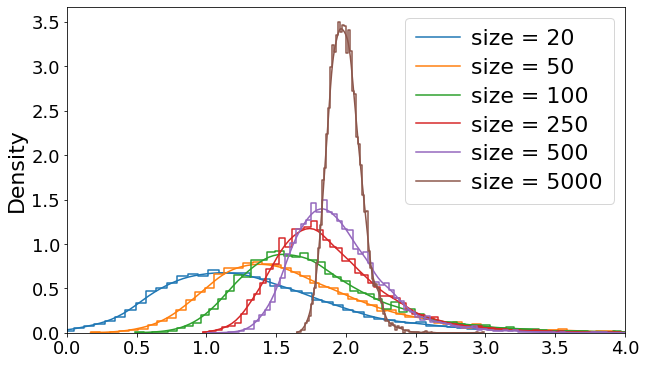

In [26]:
for sample_size in [20, 50, 100, 250, 500, 5000]:
    X = distribution.rvs(size=(sample_size, 10000))
    skewness = stats.skew(X, axis=0)
    sns.histplot(
        skewness, stat='density', 
        kde=True, fill=False, 
        element='step', label=f'size = {sample_size}')
plt.xlim(0, 4)
plt.legend()

Успех мы можем получить только в той степени, в какой исходная выборка отражает структуру распределения. То есть необходимо помнить о уровне репрезентативности исходной выборки. Так можно посмотреть на доверительные интервалы для этих данных.

In [27]:
X_new = distribution.rvs(size=(1000, 10000), random_state=23)

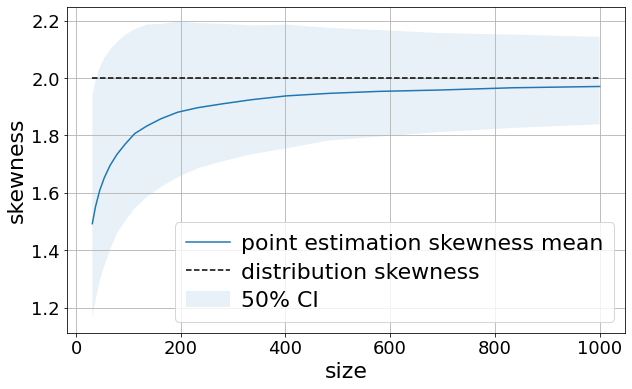

In [28]:
list_points = []
sample_sizes = np.logspace(1.5, 3, 20).astype(int)

for size in tqdm(sample_sizes):
    sub_X = X_new[:size]
    skewness = stats.skew(sub_X, axis=0)
    list_points.append(skewness)
  
alpha = 0.5

array_points = np.array(list_points)
bounds = np.quantile(array_points, [alpha/2, 1-alpha/2], axis=1)
means = np.mean(array_points, axis=1)

bounds[0], bounds[1] = 2 * means - bounds[1], 2 * means - bounds[0]

plt.fill_between(sample_sizes, bounds[0], bounds[1], alpha=0.1, label=f'{int(100 - alpha*100)}% CI')
plt.plot(sample_sizes, means, label='point estimation skewness mean')
plt.plot(sample_sizes, np.full(len(sample_sizes), distribution_skewness), '--k', label='distribution skewness')
plt.legend()
plt.xlabel('size')
plt.ylabel('skewness')
plt.grid()
plt.show()

Обратите внимание: мы построили 50% доверительный интервал! И это не просто так. С шансом 1/2 наша выборка попадет вне закрашенной области. То есть мы очень часто будем для конкретной выборки попадать очень далеко от настоящего значения.

## Почему же бутстреп популярен?

Всё очень просто. При всех ограничениях бутстрепа у нас часто нет возможности получить дополнительные данные. Т.к. получение данных <b>очень дорогое</b> удовольствие.

Поэтому бутстреп часто безальтернативен. Им стоит пользоваться. Но необходимо помнить о существующих ограничениях.

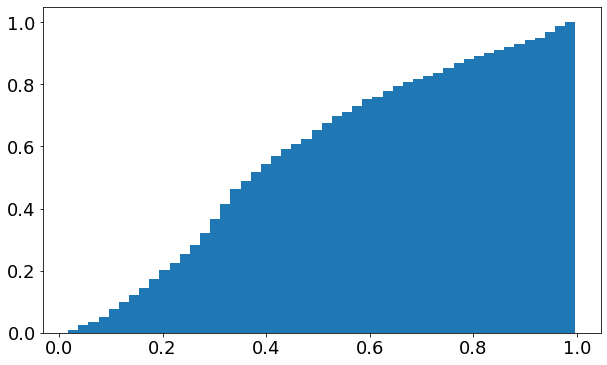

In [29]:
p_vals = []
for _ in range(1000):
  a = np.random.lognormal(-3, 3, 100)
  b = np.random.lognormal(-3, 3, 100)
  _, p_val = stats.ttest_ind(a, b)
  p_vals.append(p_val)
plt.hist(p_vals, cumulative=True, density=True, bins=50);